In [1]:
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


import numpy as np

import sqlite3

import xgboost
from xgboost import XGBRegressor

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import randint
from sklearn.model_selection import train_test_split, KFold, cross_val_score

import math

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import Lasso, Ridge
import statsmodels.api as sm

from scipy import stats
from scipy.stats import t
from scipy.stats import poisson

import seaborn as sns
import matplotlib.pyplot as plt

import pickle
import joblib

import sys
sys.path.insert(0, '../../etl/')
from columns import *

In [2]:
variable = 'RecYards'
target_variable = 'Target' + variable

### DB connect

In [3]:
conn = sqlite3.connect('../../data/nfl.db')

In [4]:
sql_path = '../../sql/RecYards/recyards_wr_backtest_training.sql'.format(variable, variable.lower())
with open(sql_path, 'r') as sql_file:
    query = sql_file.read()

raw_data = pd.read_sql_query(query, conn)
print(len(raw_data))

10252


### Split data into train/test/validation

In [5]:
# Remove inf values (there aren't many)
raw_data = raw_data.loc[~raw_data.isin([np.inf, -np.inf]).any(axis=1)]
print(len(raw_data))

10252


In [6]:
def convert_odds(american_odds):
    # Convert American Odds to Decimal Odds
    if american_odds > 0:
        decimal_odds = 1 + (american_odds / 100)
    else:
        decimal_odds = 1 - (100 / american_odds)
    return decimal_odds

In [7]:
# Prepare features
lag_features = [i for i in raw_data.columns if ('Lag' in i)]

# Convert Moneyline to Decimal odds
raw_data['Moneyline'] = raw_data['Moneyline'].apply(lambda x: convert_odds(x)) 

#features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag','PositionId']
features = [i.replace('Lag','') for i in lag_features] + ['PointTotal','Moneyline','HomeFlag']

all_features = features + [target_variable]

In [8]:
train_test_data = raw_data.copy()

# Replace Lag name in columns
train_test_data.columns = [i.replace('Lag','') for i in train_test_data.columns]

# Handle NAs and inf
#train_test_model_data = train_test_data[all_features].dropna(subset=all_features, how='any').replace([np.inf, -np.inf], np.nan).dropna()

# Split into X and y
X = train_test_data[features]
y = train_test_data[target_variable]

# Split train_test_data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)

In [17]:
X.shape

(10252, 539)

### Use random search to narrow down hyperparameter grid

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


C:\Users\Sean\anaconda3\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Best Parameters: {'colsample_bytree': 0.45334816637130043, 'gamma': 0.01836068125041057, 'learning_rate': 0.053210301652276554, 'max_depth': 3, 'min_child_weight': 7, 'n_estimators': 390, 'reg_alpha': 0.4385384885374355, 'reg_lambda': 2.186098343541303, 'subsample': 0.6983984235431582}
Best Score (R-squared): 0.25393109206660613
Test R-squared: 0.24984550110802095
Test RMSE: 31.8103
Test MAE: 24.6868


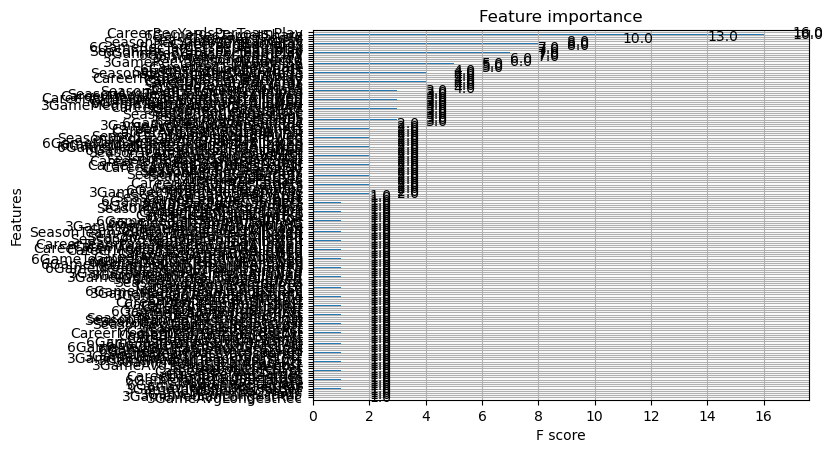

,TargetRecYards,pred_TargetRecYards,residuals
3404,18.0,27.193373,-9.193373
7630,3.0,36.746269,-33.746269
1402,104.0,37.212837,66.787163
9031,19.0,23.201252,-4.201252
8122,30.0,37.827168,-7.827168


In [10]:
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import uniform, randint
import numpy as np
import pandas as pd

# Define parameter grid for RandomizedSearchCV with improved distributions
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': uniform(0.01, 0.4),  
    'max_depth': randint(2, 10),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.3, 0.7),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.001, 10)
}

# Create XGBoost regressor with GPU support (if available)
xgb = XGBRegressor(random_state=42, use_label_encoder=False)

# Set up cross-validation strategy
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

# Create RandomizedSearchCV with efficient parameter settings
xgb_random = RandomizedSearchCV(
    estimator=xgb, 
    param_distributions=param_dist, 
    n_iter=300, 
    cv=kfolds, 
    verbose=2, 
    random_state=42, 
    n_jobs=-1
)

# Fit the model on the training data
xgb_random.fit(X_train, y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)], verbose=False)

# Display best parameters and scores
print("Best Parameters:", xgb_random.best_params_)
print("Best Score (R-squared):", xgb_random.best_score_)

# Evaluate on the test set
best_xgb = xgb_random.best_estimator_

y_pred_test = best_xgb.predict(X_test)
test_r2_score = best_xgb.score(X_test, y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print("Test R-squared:", test_r2_score)
print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Plot feature importance
plot_importance(best_xgb)
plt.show()

# Create and display output DataFrame
output_df = pd.DataFrame({target_variable: y_test, 'pred_' + target_variable: y_pred_test})
output_df['residuals'] = output_df[target_variable] - output_df['pred_' + target_variable]
output_df.head()


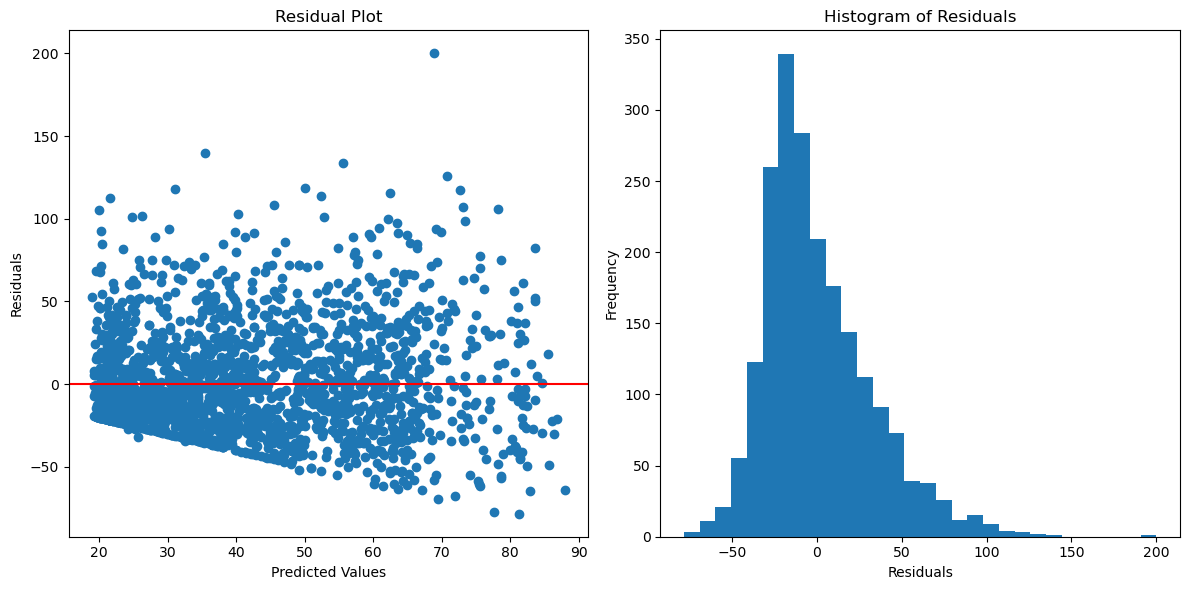

In [11]:
# Calculate residuals
residuals = y_test - y_pred_test

# Create error plots
plt.figure(figsize=(12, 6))

# Residual Plot
plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, residuals)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

# Histogram of Residuals
plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")

plt.tight_layout()
plt.show()

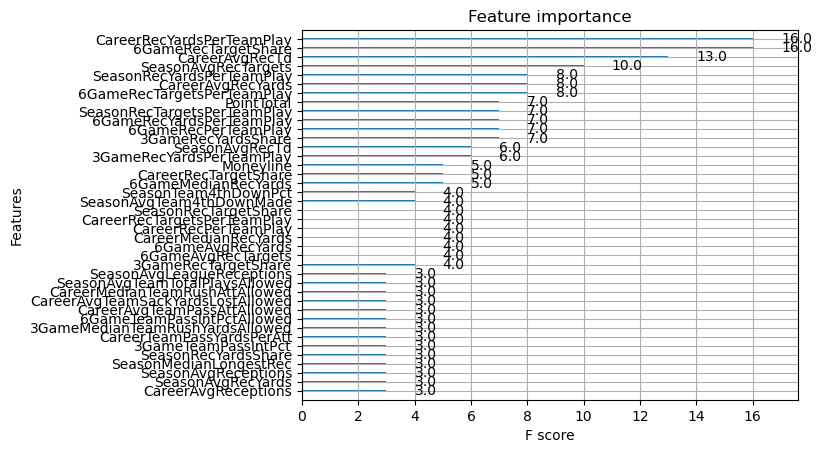

<Figure size 1800x1200 with 0 Axes>

In [12]:
# Plot feature importance
xgboost.plot_importance(best_xgb, max_num_features=40)
plt.figure(figsize=(18, 12))
plt.show()

In [13]:
train_test_data['x{}'.format(variable)] = best_xgb.predict(train_test_data[features])
train_test_data['Residual'] = train_test_data[target_variable] - train_test_data['x{}'.format(variable)]
train_test_data['AbsResidual'] = [np.abs(i) for i in train_test_data['Residual']]

train_test_data.sort_values('AbsResidual', ascending=False)[['GameDate','Player',target_variable,'x{}'.format(variable),'AbsResidual']].head(20)

,GameDate,Player,TargetRecYards,xRecYards,AbsResidual
9851,2020-11-29,Tyreek Hill,269.0,68.926788,200.073212
4534,2022-01-02,Ja'Marr Chase,266.0,67.304169,198.695831
10033,2019-10-06,Will Fuller,217.0,57.080353,159.919647
540,2019-10-06,Amari Cooper,226.0,68.628159,157.371841
4153,2022-01-23,Gabriel Davis,201.0,44.238045,156.761955
530,2018-12-09,Amari Cooper,217.0,60.475964,156.524036
5853,2021-10-10,Kadarius Toney,189.0,33.508564,155.491436
8238,2020-11-05,Richie James,184.0,31.002945,152.997055
7331,2023-01-01,Mike Evans,207.0,63.089165,143.910835
9818,2018-11-19,Tyreek Hill,215.0,72.867409,142.132591


### Persist the best model in the models dir

In [14]:
model_dir = '../../models/{}/'.format(variable)

model_file_path = model_dir + 'xgb_x{}_wr_backtest_orig.pkl'.format(variable.lower())
joblib.dump(best_xgb, model_file_path)

['../../models/RecYards/xgb_xrecyards_wr_backtest_orig.pkl']

In [15]:
# Save the model features as a file in models dir to make prod use easier
features_file_path = model_dir + 'features/xgb_x{}_wr_backtest_orig.features'.format(variable.lower())

# Open the .txt file in write mode and write the data
with open(features_file_path, 'w') as file:
    for item in features:
        file.write(f"{item}\n")

In [22]:
test = X.loc[0]

In [23]:
test.to_dict()

{'3GameAvgLongestRec': 51.0,
 '3GameAvgRecTargets': 4.0,
 '3GameAvgRecTd': 0.0,
 '3GameAvgRecYards': 100.0,
 '3GameAvgReceptions': 3.0,
 '3GameCatchPct': 0.75,
 '3GameMedianLongestRec': 51.0,
 '3GameMedianRecTargets': 4.0,
 '3GameMedianRecTd': 0.0,
 '3GameMedianRecYards': 100.0,
 '3GameMedianReceptions': 3.0,
 '3GameRecPerTeamPlay': 0.0535714285714285,
 '3GameRecShare': 0.2142857142857142,
 '3GameRecTargetShare': 0.1666666666666666,
 '3GameRecTargetsPerTeamPlay': 0.0714285714285714,
 '3GameRecYardsPerTeamPlay': 1.7857142857142858,
 '3GameRecYardsShare': 0.3571428571428571,
 '3GameYardsPerRecTarget': 25.0,
 '3GameYardsPerRush': 33.333333333333336,
 '6GameAvgLongestRec': 51.0,
 '6GameAvgRecTargets': 4.0,
 '6GameAvgRecTd': 0.0,
 '6GameAvgRecYards': 100.0,
 '6GameAvgReceptions': 3.0,
 '6GameCatchPct': 0.75,
 '6GameMedianLongestRec': 51.0,
 '6GameMedianRecTargets': 4.0,
 '6GameMedianRecTd': 0.0,
 '6GameMedianRecYards': 100.0,
 '6GameMedianReceptions': 3.0,
 '6GameRecPerTeamPlay': 0.05357142

                                 Feature  Importance
20                    6GameAvgRecTargets    0.082592
47                  CareerMedianRecYards    0.056503
22                      6GameAvgRecYards    0.047037
54             CareerRecYardsPerTeamPlay    0.042424
55                   CareerRecYardsShare    0.038390
32                   6GameRecTargetShare    0.038056
41                     CareerAvgRecYards    0.033072
33            6GameRecTargetsPerTeamPlay    0.029363
52                  CareerRecTargetShare    0.028648
61                   SeasonAvgReceptions    0.026091
34              6GameRecYardsPerTeamPlay    0.016557
38                   CareerAvgLongestRec    0.014842
29                 6GameMedianReceptions    0.012640
60                     SeasonAvgRecYards    0.011998
50                  CareerRecPerTeamPlay    0.011243
15              3GameRecYardsPerTeamPlay    0.011197
30                   6GameRecPerTeamPlay    0.011058
72           SeasonRecTargetsPerTeamPlay    0.

<Figure size 1000x800 with 0 Axes>

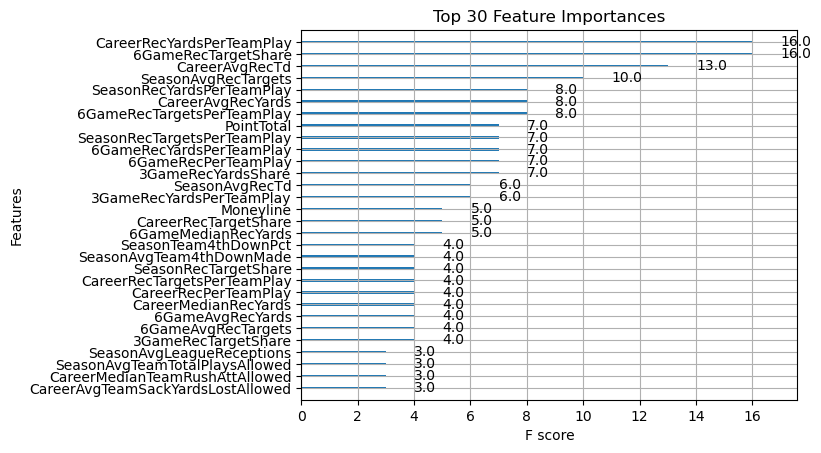

In [29]:
from xgboost import XGBRegressor, plot_importance
import pandas as pd
import matplotlib.pyplot as plt

# Assuming `best_xgb_linear` is your trained model and `X_train` is your original training data

# Step 1: Extract feature importances from the model
feature_importances = best_xgb.feature_importances_

# Step 2: Create a DataFrame to display feature names and their corresponding importance
feature_names = X_train.columns  # Use original feature names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
useful_features = importance_df[importance_df['Importance'] > 0]
print(useful_features)

# Step 3: Plot feature importance using XGBoost's built-in plotting function
plt.figure(figsize=(10, 8))
plot_importance(best_xgb, importance_type='weight', max_num_features=30)  # Plot top 30 features by default
plt.title('Top 30 Feature Importances')
plt.show()



In [31]:
useful_features.head()

,Feature,Importance
20,6GameAvgRecTargets,0.082592
47,CareerMedianRecYards,0.056503
22,6GameAvgRecYards,0.047037
54,CareerRecYardsPerTeamPlay,0.042424
55,CareerRecYardsShare,0.038390


In [34]:
useful_features.Feature.unique()

array(['6GameAvgRecTargets', 'CareerMedianRecYards', '6GameAvgRecYards',
       'CareerRecYardsPerTeamPlay', 'CareerRecYardsShare',
       '6GameRecTargetShare', 'CareerAvgRecYards',
       '6GameRecTargetsPerTeamPlay', 'CareerRecTargetShare',
       'SeasonAvgReceptions', '6GameRecYardsPerTeamPlay',
       'CareerAvgLongestRec', '6GameMedianReceptions',
       'SeasonAvgRecYards', 'CareerRecPerTeamPlay',
       '3GameRecYardsPerTeamPlay', '6GameRecPerTeamPlay',
       'SeasonRecTargetsPerTeamPlay', '3GameRecTargetShare',
       'SeasonAvgRecTargets', 'CareerAvgRecTargets',
       '6GameMedianRecTargets', 'SeasonRecYardsShare',
       'SeasonRecYardsPerTeamPlay', 'SeasonRecPerTeamPlay',
       'SeasonRecTargetShare', 'CareerRecShare', 'CareerAvgReceptions',
       'SeasonMedianLongestRec', 'CareerTeamAdjPassYardsPerAtt',
       'CareerAvgRecTd', 'CareerTeamPassCompPctAllowed',
       'SeasonMedianRecTargets', '3GameTeamAdjPassYardsPerAtt',
       'SeasonMedianTeamRushAttAllowed', 'Seas

In [45]:
test = pd.DataFrame(X.loc[0]).T
test

,3GameAvgLongestRec,3GameAvgRecTargets,3GameAvgRecTd,3GameAvgRecYards,3GameAvgReceptions,3GameCatchPct,3GameMedianLongestRec,3GameMedianRecTargets,3GameMedianRecTd,3GameMedianRecYards,3GameMedianReceptions,3GameRecPerTeamPlay,3GameRecShare,3GameRecTargetShare,3GameRecTargetsPerTeamPlay,3GameRecYardsPerTeamPlay,3GameRecYardsShare,3GameYardsPerRecTarget,3GameYardsPerRush,6GameAvgLongestRec,6GameAvgRecTargets,6GameAvgRecTd,6GameAvgRecYards,6GameAvgReceptions,6GameCatchPct,6GameMedianLongestRec,6GameMedianRecTargets,6GameMedianRecTd,6GameMedianRecYards,6GameMedianReceptions,6GameRecPerTeamPlay,6GameRecShare,6GameRecTargetShare,6GameRecTargetsPerTeamPlay,6GameRecYardsPerTeamPlay,6GameRecYardsShare,6GameYardsPerRecTarget,6GameYardsPerRush,CareerAvgLongestRec,CareerAvgRecTargets,CareerAvgRecTd,CareerAvgRecYards,CareerAvgReceptions,CareerCatchPct,CareerMedianLongestRec,CareerMedianRecTargets,CareerMedianRecTd,CareerMedianRecYards,CareerMedianReceptions,CareerPerRecTarget,CareerRecPerTeamPlay,CareerRecShare,CareerRecTargetShare,CareerRecTargetsPerTeamPlay,CareerRecYardsPerTeamPlay,CareerRecYardsShare,CareerYardsPerRec,SeasonAvgLongestRec,SeasonAvgRecTargets,SeasonAvgRecTd,SeasonAvgRecYards,SeasonAvgReceptions,SeasonCatchPct,SeasonMedianLongestRec,SeasonMedianRecTargets,SeasonMedianRecTd,SeasonMedianRecYards,SeasonMedianReceptions,SeasonPerRecTarget,SeasonRecPerTeamPlay,SeasonRecShare,SeasonRecTargetShare,SeasonRecTargetsPerTeamPlay,SeasonRecYardsPerTeamPlay,SeasonRecYardsShare,SeasonYardsPerRec,3GameAvgTeamNetPassYards,3GameAvgTeamPassAtt,3GameAvgTeamPassComp,3GameAvgTeamPassInt,3GameAvgTeamPassTd,3GameAvgTeamPassYards,3GameAvgTeamSackYardsLost,3GameAvgTeamTimesSacked,3GameMedianTeamNetPassYards,3GameMedianTeamPassAtt,3GameMedianTeamPassComp,3GameMedianTeamPassInt,3GameMedianTeamPassTd,3GameMedianTeamPassYards,3GameMedianTeamSackYardsLost,3GameMedianTeamTimesSacked,3GameTeamAdjPassYardsPerAtt,3GameTeamPassCompPct,3GameTeamPassIntPct,3GameTeamPassTdPct,3GameTeamPassYardsPerAtt,3GameTeamPassYardsPerComp,6GameAvgTeamNetPassYards,6GameAvgTeamPassAtt,6GameAvgTeamPassComp,6GameAvgTeamPassInt,6GameAvgTeamPassTd,6GameAvgTeamPassYards,6GameAvgTeamSackYardsLost,6GameAvgTeamTimesSacked,6GameMedianTeamNetPassYards,6GameMedianTeamPassAtt,6GameMedianTeamPassComp,6GameMedianTeamPassInt,6GameMedianTeamPassTd,6GameMedianTeamPassYards,6GameMedianTeamSackYardsLost,6GameMedianTeamTimesSacked,6GameTeamAdjPassYardsPerAtt,6GameTeamPassCompPct,6GameTeamPassIntPct,6GameTeamPassTdPct,6GameTeamPassYardsPerAtt,6GameTeamPassYardsPerComp,CareerAvgTeamNetPassYards,CareerAvgTeamPassAtt,CareerAvgTeamPassComp,CareerAvgTeamPassInt,CareerAvgTeamPassTd,CareerAvgTeamPassYards,CareerAvgTeamSackYardsLost,CareerAvgTeamTimesSacked,CareerMedianTeamNetPassYards,CareerMedianTeamPassAtt,CareerMedianTeamPassComp,CareerMedianTeamPassInt,CareerMedianTeamPassTd,CareerMedianTeamPassYards,CareerMedianTeamSackYardsLost,CareerMedianTeamTimesSacked,CareerTeamAdjPassYardsPerAtt,CareerTeamPassCompPct,CareerTeamPassIntPct,CareerTeamPassTdPct,CareerTeamPassYardsPerAtt,CareerTeamPassYardsPerComp,SeasonAvgTeamNetPassYards,SeasonAvgTeamPassAtt,SeasonAvgTeamPassComp,SeasonAvgTeamPassInt,SeasonAvgTeamPassTd,SeasonAvgTeamPassYards,SeasonAvgTeamSackYardsLost,SeasonAvgTeamTimesSacked,SeasonMedianTeamNetPassYards,SeasonMedianTeamPassAtt,SeasonMedianTeamPassComp,SeasonMedianTeamPassInt,SeasonMedianTeamPassTd,SeasonMedianTeamPassYards,SeasonMedianTeamSackYardsLost,SeasonMedianTeamTimesSacked,SeasonTeamAdjPassYardsPerAtt,SeasonTeamPassCompPct,SeasonTeamPassIntPct,SeasonTeamPassTdPct,SeasonTeamPassYardsPerAtt,SeasonTeamPassYardsPerComp,3GameAvgTeamRushAtt,3GameAvgTeamRushTd,3GameAvgTeamRushYards,3GameMedianTeamRushAtt,3GameMedianTeamRushTd,3GameMedianTeamRushYards,3GameTeamRushTdPct,3GameTeamYardsPerRush,6GameAvgTeamRushAtt,6GameAvgTeamRushTd,6GameAvgTeamRushYards,6GameMedianTeamRushAtt,6GameMedianTeamRushTd,6GameMedianTeamRushYards,6GameTeamRushTdPct,6GameTeamYardsPerRush,CareerAvgTeamRushAtt,CareerAvgTea

In [42]:
best_xgb.predict(test)

array([51.826275], dtype=float32)

In [43]:
test.to_dict()

{'3GameAvgLongestRec': {0: 51.0},
 '3GameAvgRecTargets': {0: 4.0},
 '3GameAvgRecTd': {0: 0.0},
 '3GameAvgRecYards': {0: 100.0},
 '3GameAvgReceptions': {0: 3.0},
 '3GameCatchPct': {0: 0.75},
 '3GameMedianLongestRec': {0: 51.0},
 '3GameMedianRecTargets': {0: 4.0},
 '3GameMedianRecTd': {0: 0.0},
 '3GameMedianRecYards': {0: 100.0},
 '3GameMedianReceptions': {0: 3.0},
 '3GameRecPerTeamPlay': {0: 0.0535714285714285},
 '3GameRecShare': {0: 0.2142857142857142},
 '3GameRecTargetShare': {0: 0.1666666666666666},
 '3GameRecTargetsPerTeamPlay': {0: 0.0714285714285714},
 '3GameRecYardsPerTeamPlay': {0: 1.7857142857142858},
 '3GameRecYardsShare': {0: 0.3571428571428571},
 '3GameYardsPerRecTarget': {0: 25.0},
 '3GameYardsPerRush': {0: 33.333333333333336},
 '6GameAvgLongestRec': {0: 51.0},
 '6GameAvgRecTargets': {0: 4.0},
 '6GameAvgRecTd': {0: 0.0},
 '6GameAvgRecYards': {0: 100.0},
 '6GameAvgReceptions': {0: 3.0},
 '6GameCatchPct': {0: 0.75},
 '6GameMedianLongestRec': {0: 51.0},
 '6GameMedianRecTargets